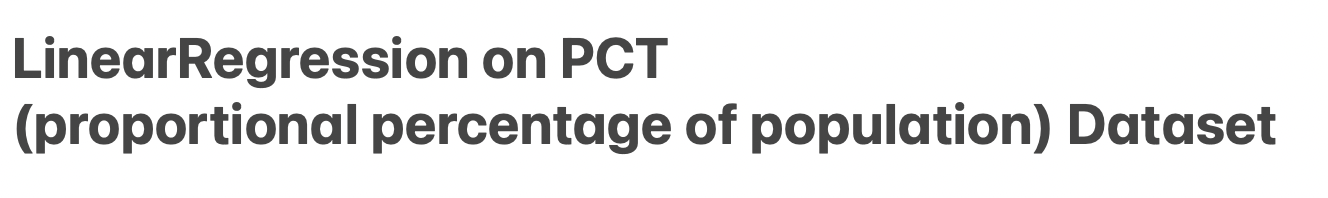

In [64]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [65]:
pct_df = pd.read_csv('data/Full_Dataset_PCT.csv')
prf_df = pd.read_csv('data/Full_Dataset_PRF.csv')

In [68]:
from sklearn.linear_model import LinearRegression

# Define the classifiers and their respective hyperparameters
# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.columns)])


# Define the classifiers and their respective hyperparameters
classifiers = {
    'LassoCV': {
        'model': LassoCV(),
        'params': {
            'cv': [3, 5, 10],
            'max_iter': [1000, 5000, 10000],
            'tol': [0.0001, 0.001, 0.01],
            'selection': ['random', 'cyclic']
        }
    },
    'RidgeCV': {
        'model': RidgeCV(),
        'params': {}
    },
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}
    }
}


# Iterate over each classifier
for name, classifier in classifiers.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', classifier['model'])])

    # Initialize the grid search
    grid_search = GridSearchCV(clf, classifier['params'], cv=5)

    # Fit the grid search
    grid_search.fit(X_train, y_train)

    # Use the best estimator to make predictions on the test set
    best_estimator = grid_search.best_estimator_
    y_pred = best_estimator.predict(X_test)

    # Compute metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{name} metrics:")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score: {grid_search.best_score_}")
    print(f"R-squared: {r2:.3f}")
    print(f"Mean Squared Error: {mse:.3f}")
    print(f"Root Mean Squared Error: {rmse:.3f}")
    print(f"Mean Absolute Error: {mae:.3f}")
    print(f"Mean Absolute Percentage Error: {mape:.3f}%")

    # Get the feature importances
    if hasattr(best_estimator.named_steps['classifier'], 'coef_'):
        importances = best_estimator.named_steps['classifier'].coef_

        # Map the features to their coefficients (importances)
        feature_importances = pd.DataFrame({"Feature": X.columns, "Importance": importances})

        # Sort by most to least important
        feature_importances = feature_importances.sort_values("Importance", ascending=False)

        # display the DataFrame
        print(feature_importances)


ValueError: Invalid parameter 'cv' for estimator Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['CITIZEN, VOTING AGE POPULATION - Female',
       'CITIZEN, VOTING AGE POPULATION - Male',
       'HISPANIC OR LATINO AND RACE - Cuban',
       'HISPANIC OR LATINO AND RACE - Hispanic or Latino (of any race)',
       'HISPANIC OR LATINO AND RACE - Mexican',
       'HISPANIC OR LATINO AND RACE - Other Hispanic or Latino',
       'HISPANIC OR LATI...
       'INDUSTRY - Wholesale trade',
       'OCCUPATION - Management, business, science, and arts occupations',
       'OCCUPATION - Natural resources, construction, and maintenance occupations',
       'OCCUPATION - Production, transportation, and material moving occupations',
       'OCCUPATION - Sales and office occupations',
       'OCCUPATION - Service occupations', 'Total households'],
      dtype='object', length=450))])),
                ('classifier', LassoCV())]). Valid parameters are: ['memory', 'steps', 'verbose'].

In [32]:
# Set 'Formatted_District' as the index
pct_df.set_index('Formatted_District', inplace=True)

# Define target variable
target = pct_df['PVI_2023']

# Define feature variables
features = pct_df.iloc[:, 3:454]
features = features.drop('Representative', axis=1) #congressperson name

# Let's display the first few rows of the features and target
features.head(), target.head()


(                    CITIZEN, VOTING AGE POPULATION - Female  \
 Formatted_District                                            
 AK-AL                                                  47.3   
 AL-01                                                  52.2   
 AL-02                                                  52.8   
 AL-03                                                  51.8   
 AL-04                                                  51.9   
 
                     CITIZEN, VOTING AGE POPULATION - Male  \
 Formatted_District                                          
 AK-AL                                                52.7   
 AL-01                                                47.8   
 AL-02                                                47.2   
 AL-03                                                48.2   
 AL-04                                                48.1   
 
                     HISPANIC OR LATINO AND RACE - Cuban  \
 Formatted_District                                   

In [33]:
# Rename target and features to y and X
y = target
X = features

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Compute the R-squared score of the model
r2 = r2_score(y_test, y_pred)
r2


-0.23380892037318257

In [34]:
import statsmodels.api as sm

# Add a constant (intercept term) to the features
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Fit an OLS model
ols_model = sm.OLS(y_train, X_train_sm)

# Fit the data
results = ols_model.fit()

# Get the R-squared score on the test set
y_pred_ols = results.predict(X_test_sm)
r2_ols = r2_score(y_test, y_pred_ols)

r2_ols


-0.23080517221248487

In [35]:
results.summary()

/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               PVI_2023   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 01 Aug 2023   Prob (F-statistic):                nan
Time:                        13:12:37   Log-Likelihood:                 6644.4
No. Observations:                 348   AIC:                        -1.259e+04
Df Residuals:                       0   BIC:                        -1.125e+04
Df Model:                         347                                         
Covariance Type:            nonrobust                                         
============================================================================================================================================================================================================================================================
                                                                                                                                                                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                                                                                                       -0.0010        inf         -0        nan         nan         nan
CITIZEN, VOTING AGE POPULATION - Female                                                                                                                                                     -1.0816        inf         -0        nan         nan         nan
CITIZEN, VOTING AGE POPULATION - Male                                                                                                                                                        0.9853        inf          0        nan         nan         nan
HISPANIC OR LATINO AND RACE - Cuban                                                                                                                                                         -0.4001        inf         -0        nan         nan         nan
HISPANIC OR LATINO AND RACE - Hispanic or Latino (of any race)                                                                                                                              -0.7214        inf         -0        nan         nan         nan
HISPANIC OR LATINO AND RACE - Mexican                                                                                                                                                        0.3151        inf          0        nan         nan         nan
HISPANIC OR LATINO AND RACE - Other Hispanic or Latino                                                                                                                                      -0.3944        inf         -0        nan         nan         nan
HISPANIC OR LATINO AND RACE - Puerto Rican                                                                                                                                                   0.4834        inf          0        nan         nan         nan
HISPANIC OR LATINO AND RACE - Two or more races                                                                                                                                             -0.4489        inf         -0        nan         nan         nan
HISPANIC OR LATINO AND RACE - Two races excludi

# Lasso Regression

In [42]:
# Initialize a StandardScaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler fitted to the training data
X_test_scaled = scaler.transform(X_test)

# Initialize a LassoCV model
lasso_model_scaled = LassoCV(cv=5)

# Fit the model on the scaled training data
lasso_model_scaled.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
y_pred_lasso_scaled = lasso_model_scaled.predict(X_test_scaled)

# Compute the R-squared score of the model
r2_lasso_scaled = r2_score(y_test, y_pred_lasso_scaled)

# Map the features to their coefficients (importances) in the scaled model
feature_importances_scaled = pd.DataFrame({"Feature": X.columns, "Importance": lasso_model_scaled.coef_})

# Sort the DataFrame by importance
feature_importances_scaled = feature_importances_scaled.sort_values("Importance", ascending=False)

r2_lasso_scaled, feature_importances_scaled


(0.886692988725742,
                                                Feature  Importance
 328               COMMUTING TO WORK - Worked from home    2.808939
 14         RACE - One race - Black or African American    2.787851
 4                HISPANIC OR LATINO AND RACE - Mexican    1.930350
 219  EDUCATIONAL ATTAINMENT - Population 25 years a...    1.579492
 208                                   ANCESTRY - Swiss    1.203753
 ..                                                 ...         ...
 180          YEAR STRUCTURE BUILT - Built 1980 to 1989   -1.121456
 431  INDUSTRY - Agriculture, forestry, fishing and ...   -1.300950
 307        Total households - Married-couple household   -1.497089
 223  EDUCATIONAL ATTAINMENT - Population 25 years a...   -1.550342
 27                             RACE - One race - White   -7.345753
 
 [450 rows x 2 columns])

In [40]:
# Map the features to their coefficients (importances)
feature_importances = pd.DataFrame({"Feature": X.columns, "Importance": lasso.coef_})

# Sort by most to least important
feature_importances = feature_importances.sort_values("Importance", ascending=False)

# display the DataFrame
feature_importances

,Feature,Importance
364,HEALTH INSURANCE COVERAGE - Unemployed:,0.000432
383,INCOME AND BENEFITS - Median earnings for fema...,0.000407
226,Females 15 years and over,0.000324
400,INCOME AND BENEFITS - Total households - Media...,0.000234
387,INCOME AND BENEFITS - Nonfamily households,0.000205
...,...,...
294,Total Civilian Noninstitutionalized Population...,-0.000054
309,VETERAN STATUS - Civilian population 18 years ...,-0.000096
338,EMPLOYMENT STATUS - Females 16 years and over ...,-0.000153
369,INCOME AND BENEFITS - Families,-0.000349


In [41]:
feature_importances.value_counts()

Feature                                                                                 Importance
ANCESTRY - American                                                                     0.0           1
SELECTED MONTHLY OWNER COSTS (SMOC) - Housing units with a mortgage - $2,500 to $2,999  0.0           1
RACE - One race - White                                                                 0.0           1
RACE - One race - Vietnamese                                                            0.0           1
RACE - One race - Some other race                                                       0.0           1
                                                                                                     ..
HOUSE HEATING FUEL - Wood                                                               0.0           1
HOUSE HEATING FUEL - Utility gas                                                        0.0           1
HOUSE HEATING FUEL - Solar energy                                    

In [47]:
# Count the number of coefficients that were shrunk to zero
num_zero_coefs = (lasso_model_scaled.coef_ == 0).sum()

num_zero_coefs

357

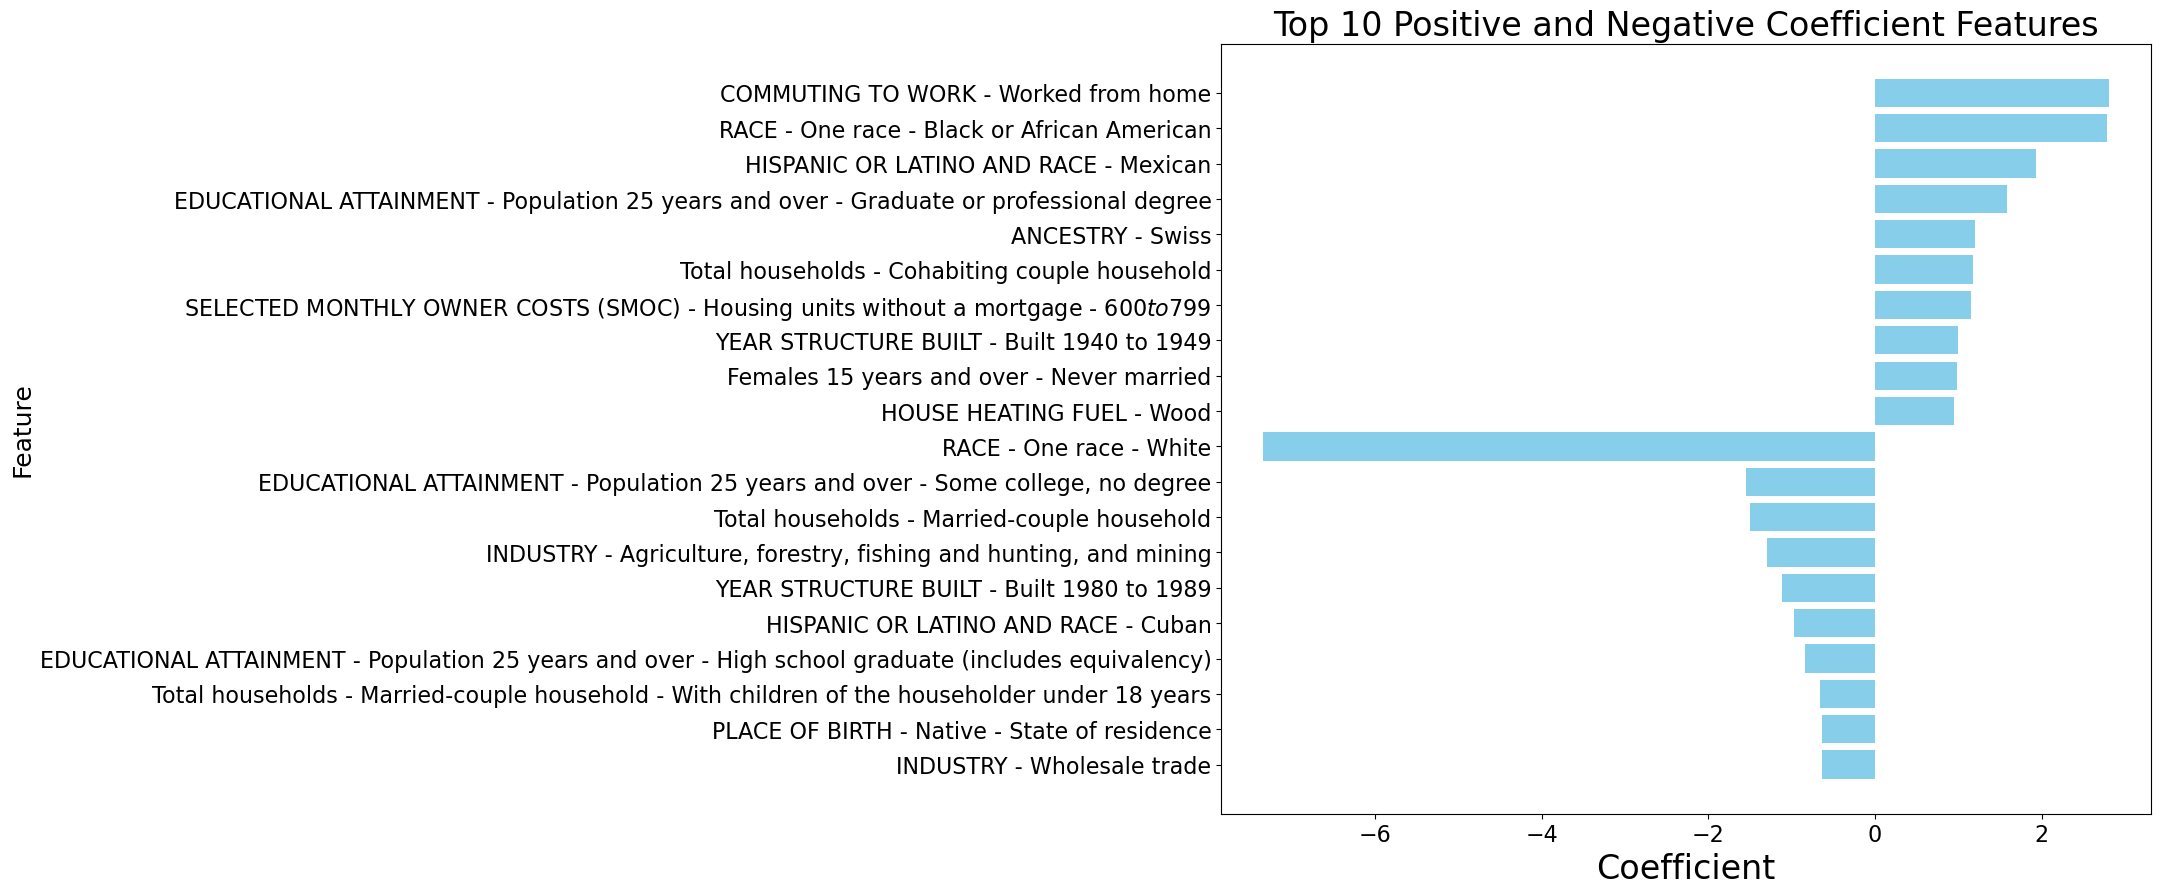

In [56]:
import matplotlib.pyplot as plt

# Create a DataFrame of non-zero coefficients
non_zero_coefs = feature_importances_scaled[feature_importances_scaled["Importance"] != 0]

# Get the top 10 positive and top 10 negative coefficient features
top_pos = non_zero_coefs.sort_values("Importance", ascending=False).head(10)
top_neg = non_zero_coefs.sort_values("Importance").head(10)

# Combine the top positive and negative features
top_features = pd.concat([top_pos, top_neg])

# Create a bar plot of the feature importances
plt.figure(figsize=(12, 10))
plt.barh(top_features["Feature"], top_features["Importance"], color='skyblue')
plt.xlabel("Coefficient", fontsize=24)
plt.ylabel("Feature", fontsize=18)
plt.title("Top 10 Positive and Negative Coefficient Features", fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.gca().invert_yaxis()
plt.show()




In [52]:
# Print the list of all non-zero features
non_zero_features = non_zero_coefs["Feature"].tolist()
non_zero_features

['COMMUTING TO WORK - Worked from home',
 'RACE - One race - Black or African American',
 'HISPANIC OR LATINO AND RACE - Mexican',
 'EDUCATIONAL ATTAINMENT - Population 25 years and over - Graduate or professional degree',
 'ANCESTRY - Swiss',
 'Total households - Cohabiting couple household',
 'SELECTED MONTHLY OWNER COSTS (SMOC) - Housing units without a mortgage - $600 to $799',
 'YEAR STRUCTURE BUILT - Built 1940 to 1949',
 'Females 15 years and over - Never married',
 'HOUSE HEATING FUEL - Wood',
 'ANCESTRY - Swedish',
 'ANCESTRY - French Canadian',
 'HEALTH INSURANCE COVERAGE - Not in labor force: - With public coverage',
 'EMPLOYMENT STATUS - Females 16 years and over - In labor force',
 'SELECTED MONTHLY OWNER COSTS AS A PERCENTAGE OF HOUSEHOLD INCOME (SMOCAPI) - Housing unit without a mortgage (excluding units where SMOCAPI cannot be computed) - 10.0 to 14.9 percent',
 'INDUSTRY - Professional, scientific, and management, and administrative and waste management services',
 'WO

In [58]:
# Scaling the feature set again
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Converting to DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Using the non-zero features from the Lasso regression to build a new OLS model
X_lasso = X_scaled[non_zero_features]

# Resetting the index of y
y_reset = y.reset_index(drop=True)


X_lasso = sm.add_constant(X_lasso)
ols_lasso = sm.OLS(y_reset, X_lasso)

ols_lasso_results = ols_lasso.fit()
ols_lasso_results.summary()





<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               PVI_2023   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     108.2
Date:                Tue, 01 Aug 2023   Prob (F-statistic):          1.95e-207
Time:                        13:51:31   Log-Likelihood:                -1094.5
No. Observations:                 435   AIC:                             2373.
Df Residuals:                     343   BIC:                             2748.
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
============================================================================================================================================================================================================================================================
                                                                                                                                                                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                                                                                                        0.3917      0.162      2.422      0.016       0.074       0.710
COMMUTING TO WORK - Worked from home                                                                                                                                                         3.2933      0.673      4.891      0.000       1.969       4.618
RACE - One race - Black or African American                                                                                                                                                  3.9907      0.762      5.236      0.000       2.492       5.490
HISPANIC OR LATINO AND RACE - Mexican                                                                                                                                                        3.0108      0.607      4.957      0.000       1.816       4.206
EDUCATIONAL ATTAINMENT - Population 25 years and over - Graduate or professional degree                                                                                                      0.2987      0.822      0.363      0.717      -1.319       1.916
ANCESTRY - Swiss                                                                                                                                                                             1.1929      0.253      4.711      0.000       0.695       1.691
Total households - Cohabiting couple household                                                                                                                                               1.6832      0.398      4.229      0.000       0.900       2.466
SELECTED MONTHLY OWNER COSTS (SMOC) - Housing units without a mortgage - $600 to $799                                                                                                        1.3416      0.346      3.876      0.000       0.661       2.022
YEAR STRUCTURE BUILT - Built 1940 to 1949                                                                                                                                                    0.2928      0.410      0.715      0.475      -0.513       1.099
Females 15 years and over - Never married      

In [59]:
# Convert non-zero features and their coefficients to a DataFrame
non_zero_df = pd.DataFrame({'Feature': non_zero_features, 'Coefficient': lasso_model_scaled.coef_[lasso_model_scaled.coef_ != 0]})
non_zero_df

,Feature,Coefficient
0,COMMUTING TO WORK - Worked from home,-0.978585
1,RACE - One race - Black or African American,1.930350
2,HISPANIC OR LATINO AND RACE - Mexican,2.787851
3,EDUCATIONAL ATTAINMENT - Population 25 years a...,-0.198294
4,ANCESTRY - Swiss,-0.079044
...,...,...
88,YEAR STRUCTURE BUILT - Built 1980 to 1989,0.387618
89,"INDUSTRY - Agriculture, forestry, fishing and ...",0.208112
90,Total households - Married-couple household,-1.300950
91,EDUCATIONAL ATTAINMENT - Population 25 years a...,0.515483


In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to calculate mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate the metrics for the Lasso model
mse = mean_squared_error(y_test, y_pred_lasso_scaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_lasso_scaled)
mape = mean_absolute_percentage_error(y_test, y_pred_lasso_scaled)

mse, rmse, mae, mape


(24.59424004302052, 4.95925801335447, 3.930716579821291, 173.11809417987055)

In [61]:
# Get the average of the non-zero coefficient features in their non-scaled form
avg_non_zero_features = X[non_zero_features].mean()
avg_non_zero_features


COMMUTING TO WORK - Worked from home                                                       17.384598
RACE - One race - Black or African American                                                12.043678
HISPANIC OR LATINO AND RACE - Mexican                                                      11.215632
EDUCATIONAL ATTAINMENT - Population 25 years and over - Graduate or professional degree    13.639080
ANCESTRY - Swiss                                                                            0.254483
                                                                                             ...    
YEAR STRUCTURE BUILT - Built 1980 to 1989                                                  13.079540
INDUSTRY - Agriculture, forestry, fishing and hunting, and mining                           1.630115
Total households - Married-couple household                                                47.571494
EDUCATIONAL ATTAINMENT - Population 25 years and over - Some college, no degree            

In [14]:
# Set 'Formatted_District' as the index
prf_df.set_index('Formatted_District', inplace=True)

# Define target variable
target = prf_df['PVI_2023']

# Define feature variables
features = prf_df.iloc[:, 3:454]
features = features.drop('Representative', axis=1) #congressperson name

# Let's display the first few rows of the features and target
features.head(), target.head()


(                    CITIZEN, VOTING AGE POPULATION - Female  \
 Formatted_District                                            
 AK-AL                                              252485.0   
 AL-01                                              289663.0   
 AL-02                                              284652.0   
 AL-03                                              289423.0   
 AL-04                                              280884.0   
 
                     CITIZEN, VOTING AGE POPULATION - Male  \
 Formatted_District                                          
 AK-AL                                            281367.0   
 AL-01                                            265460.0   
 AL-02                                            254358.0   
 AL-03                                            269129.0   
 AL-04                                            260374.0   
 
                     HISPANIC OR LATINO AND RACE - Cuban  \
 Formatted_District                                   

In [15]:
# Rename target and features to y and X
y = target
X = features

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Compute the R-squared score of the model
r2 = r2_score(y_test, y_pred)
r2

-0.8848183663154758

In [ ]:
import statsmodels.api as sm

# Add a constant (intercept term) to the features
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Fit an OLS model
ols_model = sm.OLS(y_train, X_train_sm)

# Fit the data
results = ols_model.fit()

# Get the R-squared score on the test set
y_pred_ols = results.predict(X_test_sm)
r2_ols = r2_score(y_test, y_pred_ols)

r2_ols
